## Bank Term Deposit Acceptance forecasting

Obiettivo di questo assignment è la valutazione delle competenze tecniche del candidato e la sua modalità di approccio ad un problema di Data Science. Nello specifico è richiesto di sviluppare un modello predittivo in grado di indicare se un cliente intercettato da una campagna di marketing da parte di una banca decide di sottoscrivere o meno un deposito bancario a termine (bank term deposit).

#### Dataset: ####

All'interno della cartella **data**  viene fornito il file **bank-dataset.csv** che contiene le campagne marketing telefoniche effettuate da una banca per proporre l'acquisto del prodotto bancario.
I dettagli del dataset sono forniti all'interno del file: **bank-names.txt**.
La variabile target che indica se il cliente accetta o meno la sottoscrizione del deposito bancario è contenuta nel medesimo file con field name "y".

#### Assignement: ####

Richiesta di questo assignment è la costruzione di un modello predittivo con performance soddisfacenti per il candidato dando evidenza di tutti gli step tipici che dovrebbero essere affrontati in un progetto di Data Science: dalla pulizia e preparazione del dato fino al testing delle performance del modello costruito.

Il notebook svolto dovrà essere opportunamente commentato e dovrà essere consegnato tramite condivisione di un repository github personale accessibile che ne permetta la riproduzione.

In [1]:
#import tensorflow as tf
import pandas as pd
import pandas_profiling
import numpy as np
import yaml
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, SCORERS
#from focal_loss import BinaryFocalLoss
from typing import Tuple, Union

import seaborn as sns
from matplotlib import pyplot as plt
from xgboost import XGBClassifier, XGBRegressor

from ray import tune
from xgboost_ray import RayDMatrix, RayParams, train

## Data Loader
The data are loaded and parsed from the .csv file and store into a tf.data object



In [2]:
def load_df(data_path:str='data/bank-dataset.csv', features_path:str='data/features.yaml', raw:bool=False, debug:bool=False) -> Tuple[pd.DataFrame, np.array, dict]:
    """
    Load the data.csv as pandas DataFrame and clean the dataset

    Args:
        data_path (str, optional): relative path to data.csv. Defaults to 'data/bank-dataset.csv'.
        features_path (str, optional): relative path to feature specs. Defaults to 'data/features.yaml'.
        raw (bool, optional): skip the cleaning phase. Defaults to False.bit_length.
        debug (bool, optional): informative print. Defaults to False.

    Returns:
        pd.DataFrame: loaded and cleaned dataset
        dict: loaded features specs
    """
    
    df = pd.read_csv(data_path)
    features = yaml.load(open(features_path, 'r'), Loader=yaml.SafeLoader)
    if raw: df, features
    n_samples = df.shape[0]
    n_pos = df.y.value_counts()['yes']

    # handle the empty cells
    df.loc[df.contact.isnull(), 'contact'] = 'unknown'
    df.loc[df.poutcome.isnull(), 'poutcome'] = 'unknown'
    df.loc[df.duration.isnull(), 'duration'] = -1.0
    df = df.dropna(axis=0, how='any')

    for feat, specs in features.items():
        
        # remove samples with outliers numerical values
        if specs['type'] == 'numerical':
            if 'max' in specs and specs['max'] is not None:
                max_val = specs['max']
                if max_val < 1: max_val = df[feat].quantile(max_val)
                df = df.drop(df[df[feat] > max_val].index)
        
        # set string value to lowercase
        elif specs['type'] in ['ordinal', 'categorical']:
            df[feat] = df[feat].map(lambda x: x.lower())
    
    # reformat marital status
    df.loc[df.marital == 'divrcd', 'marital'] = 'divorced'
    df.loc[df.marital == 's', 'marital'] = 'single'
    df.loc[df.marital == 'singl', 'marital'] = 'single'
    
    # make the output binary
    #df.y = np.where(df.y=='yes', 1, 0)
    
    if debug: 
        print(f"Dropped {n_samples-df.shape[0]} ({100*(n_samples-df.shape[0])/n_samples:.1f}%) samples")
        print(f"Dropped {n_pos-df.y.value_counts()['yes']} ({100*(n_pos-df.y.value_counts()['yes'])/n_pos:.1f}%) positive samples")
    return df, features

In [3]:
def midsampling(df:pd.DataFrame, debug:bool=False) -> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): dataset loaded as pandas Dataframe. 
        debug (bool, optional): informative print. Defaults to False.

    Returns:
        pd.DataFrame: resampled DataFrame.
    """
    info = ""
    # split the data into different classes
    df0 = df[df.y==0]
    df1 = df[df.y==1]
    info += f"Unbalance ds (no:{df0.shape[0]}, yes:{df1.shape[0]}) → "
    # resample each class
    df0 = resample(df0, n_samples=df.shape[0]//2)
    df1 = resample(df1, n_samples=df.shape[0]//2)
    info += f"Resampled ds (no:{df0.shape[0]}, yes:{df1.shape[0]})"
    # merge the resampled classes
    df = pd.concat([df0, df1])
    if debug: print(info)
    return df

In [4]:
def get_train_test_dataset(df:pd.DataFrame, test_size:Union[int, float]=.2, as_numpy:bool=False, debug:bool=False):
    """
    Take the leaded data and split into two independent sets.

    Args:
        df (pd.DataFrame): dataset loaded as pandas Dataframe. 
        test_size (int|float, optional): 
            If <1 portion of dataset to use as test, 
            otherwise the number of samples. Defaults to 0.2.
        as_numpy (bool, optional): return arrays instead of dataset
        debug (bool, optional): informative print. Defaults to False.

    Returns:
        list(tf.data.Dataset): train and test dataset
        list(np.array): train/test features/labels arrays
    """
    
    x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='y'), df.y, test_size=test_size, stratify=df.y, random_state=RND_SEED)
    if debug: print(f"Train samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")
    
    # make feature dataframe a dict
    x_train = {name:np.array(values) for name, values in x_train.items()}
    x_test = {name:np.array(values) for name, values in x_test.items()}
    # make label datafram a binary array
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    if as_numpy:
        return x_train, x_test, y_train, y_test
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    
    return train_ds, test_ds
    

In [ ]:
### Export pandas report to study the data distribution
df_feature, df_label, features = load_df()
df_profile = df.profile_report(minimal=True)
df_profile.to_file(output_file='data/report_refactor.html')

In [ ]:
df, features = load_df(raw=False)
df.loc[df.y=='no', 'y'] = 0
df.loc[df.y=='yes', 'y'] = 1

fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.histplot(x=df['age'], hue=df['y'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axarr[0][0])
sns.histplot(x=df['job'], hue=df['y'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axarr[0][1])
sns.histplot(x=df['marital'], hue=df['y'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axarr[1][0])
sns.histplot(x=df['education'], hue=df['y'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axarr[1][1])

#sns.countplot(x='age', hue='y',data=df, ax=axarr[0][0])
#sns.countplot(x='job', hue='y',data=df, ax=axarr[0][1])
#sns.countplot(x='marital', hue='y',data=df, ax=axarr[1][0])
#sns.countplot(x='education', hue='y',data=df, ax=axarr[1][1])

In [ ]:
df, features = load_df(raw=False)
df.loc[df.y=='no', 'y'] = 0
df.loc[df.y=='yes', 'y'] = 1
'''for feat, info in features.items():
    if info['type'] != 'numerical' and feat != 'y':
        df = df.drop(columns=feat)'''

fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='age', x='marital', hue='y',data=df, ax=axarr[0][0])
sns.violinplot(data=df, x="marital", y="age", hue="y",
               split=True, inner="quart", linewidth=1, ax=axarr[1][0])

## Model

The model is composed by 2 main parts:

#### **Preprocessing model**

Take as input a dictionary with the raw data (string and integer values) and return a float tensor that fit the predictive model.
       
The features are processed as followed:
- **Numerifcal** features are normalized between (0, 1)
- **Ordinal Categorical** features are mapped as incremental integer
- **Categorical** features are One-Hot encoded
 
#### **Predictive model**

Take as input the encoded tensor and return the prediction

In [4]:
def get_input_spec(df:pd.DataFrame):
    """
    Create a dict with the shape and type of each feature, 
    required by the tf.Model initialization

    Args:
        df (pd.DataFrame): dataset loaded aspandas DataFrame

    Returns:
        dict: dict with shape and type for each feature
    """

    inputs = {}
    _df = df.drop(columns='y') if 'y' in df.columns else df
    for name, column in _df.items():
        dtype = column.dtype
        if dtype == object:
            dtype = tf.string
        else:
            dtype = tf.float32
        inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
    return inputs

In [5]:
def preprocess_data(df, features):
    for name, value in features.items():
        # map each class to an incremental integer
        if features[name]['type'] == 'ordinal':
            df[name] = df[name].map({feat: i for i, feat in enumerate(features[name]['classes'])})
        # one hot encode the categorical features
        elif features[name]['type'] == 'categorical':
            df = df.assign(**pd.get_dummies(df[name], prefix=name))
            df = df.drop(columns=name)
        # normalize the numerical data
        elif features[name]['type'] == 'numerical':
            continue
            if 'max' in features[name] and features[name]['max'] is not None:
                max_value = features[name]['max']
                if max_value < 1: max_value = df[name].quantile(max_value)
                df[name] = df[name] / max_value
        else:
            raise Exception("Unknown data type", features[name]['type'])
        
    return df

In [7]:
def get_preprocessing_model(df:pd.DataFrame, features:dict, inputs:dict) -> tf.keras.Model:
    """
    Initialize the preprocessing model, which take the raw features as input
    and return a float tensor that fit the predictive model

    Args:
        df (pd.DataFrame): dataset as padas DataFrame
        features (dict): features specification
        inputs (dict): input specs for the tf.Model

    Raises:
        Exception: unknown feature type

    Returns:
        tf.keras.Model: model for the input preprocessing
    """
    
    preprocessed_inputs = []
    for name, value in inputs.items():
        # map each class to an incremental integer
        if features[name]['type'] == 'ordinal':
            layer = tf.keras.layers.StringLookup(vocabulary=features[name]['classes'])
            prep_val = layer(value)
        # one hot encode the categorical features
        elif features[name]['type'] == 'categorical':
            layer = tf.keras.layers.StringLookup(vocabulary=features[name]['classes'], output_mode='one_hot')
            prep_val = layer(value)
        # normalize the numerical data
        elif features[name]['type'] == 'numerical':
            if 'max' in features[name]:
                max_value = features[name]['max']
                if max_value < 1: max_value = df[name].quantile(max_value)
                prep_val = value / max_value
            else:
                prep_val = value
        else:
            raise Exception("Unknown data type", features[name]['type'])
        
        prep_val = tf.cast(prep_val, tf.float32)
        preprocessed_inputs.append(prep_val)
    
    preprocessing_outputs = tf.keras.layers.Concatenate()(preprocessed_inputs)
    preprocessing_model = tf.keras.Model(inputs, preprocessing_outputs, name="preprocessing_model")

    return preprocessing_model

In [7]:
def get_model(df:pd.DataFrame, features:dict, hidden_units:list, act_function:str) -> tf.keras.Model:
    """
    Initialize the neural network

    Args:
        df (pd.DataFrame): dataset as padas DataFrame
        features (dict): features specification

    Returns:
        tf.keras.Model: predictive model
    """
    inputs = get_input_spec(df)
    preprocessing_model = get_preprocessing_model(df, features, inputs)

    layers = []
    for units in hidden_units:
        layers.append(tf.keras.layers.Dense(units, activation=act_function))
    layers.append(tf.keras.layers.Dense(1))
    predictive_model = tf.keras.Sequential(layers, name="predictive_model")

    output = preprocessing_model(inputs)
    output = predictive_model(output)

    model = tf.keras.Model(inputs, output)
    return model

#### XGBoost

In [6]:
def plot_roc_curve(y_true, y_proba, savefig=None):
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], '--k')
    if savefig: plt.savefig(savefig)
    plt.show()
    
def plot_heatmap(y_true, y_pred, savefig=None):
    plt.figure()
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    hm = sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap=sns.cm.rocket_r)
    hm.set(xlabel='Prediction', ylabel='Ground truth')
    hm.set(xticklabels=features['y']['classes'], yticklabels=features['y']['classes'])
    if savefig: plt.savefig(savefig)
    plt.show()

In [7]:
### SINGLE RUN! ###
from pathlib import Path

def run(config):

    df, features = load_df('/home/stefano/Projects/Fastweb/data/bank-dataset.csv', '/home/stefano/Projects/Fastweb/data/features.yaml', debug=False)
    df = preprocess_data(df, features)
    train_df, test_df = train_test_split(df, test_size=.2, stratify=df.y)
    train_df = midsampling(train_df, debug=False)

    model = XGBClassifier(use_label_encoder=False, 
                          eval_metric='auc',
                          max_depth=int(config['max_depth']), 
                          n_estimators=int(config['n_estimators']),
                          eta=config['eta'], 
                          subsample=config['subsample'], 
                          colsample_bytree=config['colsample_bytree'],
                          min_child_weight=config['min_child_weight']
                          )
    model.fit(train_df.drop(columns='y'), train_df.y)

    y_proba = model.predict(test_df.drop(columns='y'), output_margin=True)
    y_pred = model.predict(test_df.drop(columns='y'))
    
    AUC = roc_auc_score(test_df.y, y_proba)
    scores = classification_report(test_df.y, y_pred, digits=3, target_names=features['y']['classes'], output_dict=True)

    in_ray = True
    if in_ray:
        return {"loss":-AUC, "status": STATUS_OK}
        tune.session.report({"AUC": AUC, "done": True})
    else:
        print(classification_report(test_df.y, y_pred, digits=3, target_names=features['y']['classes']))
        print(f"AUC {AUC:3f}")
        plot_roc_curve(test_df.y, y_proba)
        plot_heatmap(test_df.y, y_pred)
    

In [375]:
## SCORING CROSS VALIDATION

df, features = load_df(debug=True)
df = preprocess_data(df, features)
train_df, test_df = train_test_split(df, test_size=.2, stratify=df.y)
train_df = midsampling(train_df, debug=True)

model = XGBClassifier(use_label_encoder=False, eval_metric='auc', max_depth=23, n_estimators=30,
                      eta=0.05, subsample=0.5, colsample_bytree=0.5)

scores = cross_validate(model, train_df.drop(columns='y'), train_df.y, scoring=['roc_auc', 'f1'], cv=7, return_train_score=True)
scores

Dropped 193 (0.4%) samples
Dropped 48 (1.5%) positive samples
Unbalance ds (no:31824, yes:2499) → Resampled ds (no:17161, yes:17161)


{'fit_time': array([0.98282719, 0.9848218 , 1.1980083 , 0.83306694, 0.91609955,
        0.8305285 , 0.8546412 ]),
 'score_time': array([0.01203418, 0.01177263, 0.01142621, 0.01291323, 0.01097631,
        0.01162887, 0.01220417]),
 'test_roc_auc': array([0.99038089, 0.98907244, 0.98875363, 0.98745626, 0.98867077,
        0.98910888, 0.99055434]),
 'train_roc_auc': array([0.99704012, 0.99707775, 0.99719522, 0.99715926, 0.99692197,
        0.99688591, 0.99706897]),
 'test_f1': array([0.95535362, 0.95657323, 0.95334124, 0.94968553, 0.95283205,
        0.95166994, 0.95853081]),
 'train_f1': array([0.97576629, 0.97493593, 0.97417958, 0.97478432, 0.97400347,
        0.97259363, 0.97498918])}

Dropped 193 (0.4%) samples
Dropped 48 (1.5%) positive samples


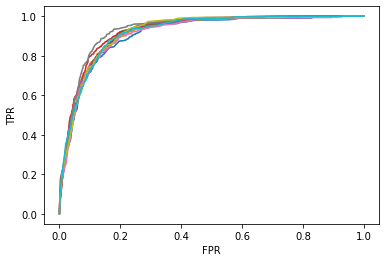

In [373]:
df, features = load_df(debug=True)
df = preprocess_data(df, features)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RND_SEED)

for i, (train_ids, test_ids) in enumerate(skf.split(df.drop(columns='y'), df.y)):
    train_df, test_df = df.iloc[train_ids], df.iloc[test_ids]
    model = XGBClassifier(use_label_encoder=False, eval_metric='auc', max_depth=23, n_estimators=30,
                          eta=0.05, subsample=0.5, colsample_bytree=0.5)
    model.fit(train_df.drop(columns='y'), train_df.y)
    
    y_proba = model.predict(test_df.drop(columns='y'), output_margin=True)
    fpr, tpr, _ = roc_curve(test_df.y, y_proba)
    res = {'FPR':fpr, 'TPR':tpr}
    sns.lineplot(data=res, x="FPR", y="TPR")

In [8]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

config = {
        "eval_metric": ["auc"],
        "max_depth": hp.quniform('max_depth', 1, 30, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        "n_estimators": hp.quniform('n_estimators', 1, 30, 1),
        "subsample": hp.uniform('subsample', 0.5, 1.0),
        "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        "eta": hp.loguniform('eta', 1e-4, 1e-1)
    }

trials = Trials()

best_hyperparams = fmin(fn = run,
                        space = config,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        verbose=1)




'''algo_hyperopt = HyperOptSearch(config, metric='AUC', mode='max', n_initial_points=10)
scheduler_asha = ASHAScheduler(
    time_attr='training_iteration',
    metric='AUC', mode='max',
    max_t=60,
    grace_period=7,
    reduction_factor=4,
)

analysis = tune.run(
    run,
    metric='AUC', mode='max',
    #scheduler=scheduler_asha, search_alg=algo_hyperopt,
    config=config,
    local_dir='./results',
    trial_name_creator=lambda trial: trial.trainable_name + '_' + trial.trial_id,
    resources_per_trial={'gpu': 1},
    num_samples = 2
    )
'''

100%|██████████| 100/100 [02:24<00:00,  1.44s/trial, best loss: -0.9256452488687783]


"algo_hyperopt = HyperOptSearch(config, metric='AUC', mode='max', n_initial_points=10)\nscheduler_asha = ASHAScheduler(\n    time_attr='training_iteration',\n    metric='AUC', mode='max',\n    max_t=60,\n    grace_period=7,\n    reduction_factor=4,\n)\n\nanalysis = tune.run(\n    run,\n    metric='AUC', mode='max',\n    #scheduler=scheduler_asha, search_alg=algo_hyperopt,\n    config=config,\n    local_dir='./results',\n    trial_name_creator=lambda trial: trial.trainable_name + '_' + trial.trial_id,\n    resources_per_trial={'gpu': 1},\n    num_samples = 2\n    )\n"

## Training

In [18]:
## HYPER-PARAMETERS
batch_size = 100
act_function = 'tanh'
hidden_units = [512, 256, 128, 64, 32]
optimizer = 'nadam'

#loss_function = BinaryFocalLoss(gamma=4)
loss_function = "binary_crossentropy"

metrics = ['accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()]

RND_SEED = 42
debug = True

In [15]:
# Load the dataset
df, features = load_df(debug=debug)
#df = midsampling(df, debug)
train_ds, test_ds = get_train_test_dataset(df, test_size=2000, debug=debug)

train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

Dropped 4153 (9.6%) samples
Train samples: 36944, Test samples: 2000


In [19]:
# Initialize the model
#tf.keras.backend.clear_session()
model = get_model(df, features, hidden_units, act_function)

model.compile(optimizer=optimizer, 
              loss=loss_function,
              metrics=metrics)

In [20]:
from datetime import datetime

# Train the model
log_dir = "logs/" + datetime.now().strftime("%m%d-%H%M%S")
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir)
]
history = model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=callbacks)
print("train done!")

Epoch 1/100
370/370 [==============================] - 5s 9ms/step - loss: 0.9631 - accuracy: 0.9359 - precision_2: 0.0278 - recall_2: 8.6957e-04 - val_loss: 1.0103 - val_accuracy: 0.9345 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/100
370/370 [==============================] - 3s 7ms/step - loss: 0.9603 - accuracy: 0.9377 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0103 - val_accuracy: 0.9345 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/100
370/370 [==============================] - 2s 6ms/step - loss: 0.9603 - accuracy: 0.9377 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0103 - val_accuracy: 0.9345 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/100
370/370 [==============================] - 2s 5ms/step - loss: 0.9603 - accuracy: 0.9377 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0103 - val_accuracy: 0.9345 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/

In [ ]:
model.evaluate(test_ds)